In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

filepath_processed = 'C:/Users/Dirk/Google Drive/Dirk/TU/Afstuderen/Afstuderen/Thesis/3. Formalisation/Processed CBS data/'
filepath_raw = 'C:/Users/Dirk/Google Drive/Dirk/TU/Afstuderen/Afstuderen/Thesis/3. Formalisation/Raw CBS data/'
filepath_other = 'C:/Users/Dirk/Google Drive/Dirk/TU/Afstuderen/Afstuderen/Thesis/3. Formalisation/Raw data other/'

In [2]:
#timeit.timeit(pd.read_csv(filepath_processed + 'Total_dataset.csv'))
start = datetime.now()
data =  pd.read_csv(filepath_processed + 'Total_dataset.csv', index_col = 0, 
                    dtype = {'gemeente': str ,'postcode': str ,'huisnummer' : int ,
                             'huisletter': str ,'huisnummertoevoeging': str , 
                             'oppervlakteverblijfsobject' : float ,'pandbouwjaar' : int ,
                             'openbareruimte' : str ,'pandstatus' : str , 'Woningkenmerken': str ,
                             'Energielabel' : str,'leeftijd' : int ,'Age group': str, 
                             'GebruiksOppervlakteklasse' : str,'Bouwjaarklasse' : str,
                             'gasverbruik m3/m2' : float ,'geschat gasverbruik jaarlijks' : float, 
                             'Gemiddelde grootte huishouden' : float , 
                             'elektriciteits verbruik pp' : float , 
                             'geschat elektriciteitsverbruik jaarlijks' : float})

print ('Loading huge dataset took: ' + str((datetime.now()-start).total_seconds()) + ' seconds')

buurten = pd.read_csv(filepath_raw + 'postcode_huisnummer_buurten.csv',delimiter = ';')
wijk = pd.read_csv(filepath_raw + 'wijk2019.csv', delimiter = ';')
buurt = pd.read_csv(filepath_raw + 'buurt2019.csv', delimiter = ';')


C:\Users\Dirk\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Dirk\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Loading huge dataset took: 29.688393 seconds


In [3]:
wijk_dict = wijk.astype(str).set_index('Wijkcode2019').to_dict()['Wijknaam_2019K_NAAM']
buurt.Buurtcode_2019 = buurt.Buurtcode_2019.astype(str)
buurt_dict = buurt.set_index('Buurtcode_2019').to_dict()['Buurtnaam_2019']

buurten[['Buurt2019']]= buurten[['Buurt2019']].astype(str)
buurten[['Wijk2019']] = buurten[['Wijk2019']].astype(str)
buurten['buurt_naam'] = buurten['Buurt2019'].map(buurt_dict)
buurten['wijk_naam'] = buurten['Wijk2019'].map(wijk_dict)
buurten = buurten.drop(['Buurt2019','Wijk2019','Gemeente2019'], axis = 1).rename(columns = {'PC6':'postcode','Huisnummer':'huisnummer'})

In [4]:
data = data.merge(buurten, on = ['postcode','huisnummer'], how = 'inner')

In [5]:
data.columns

Index(['gemeente', 'postcode', 'huisnummer', 'huisletter',
       'huisnummertoevoeging', 'oppervlakteverblijfsobject', 'pandbouwjaar',
       'openbareruimte', 'pandstatus', 'Woningkenmerken', 'Energielabel',
       'CBSCATEGOR', 'RIJKSMONNR', 'leeftijd', 'Age group',
       'GebruiksOppervlakteklasse', 'Bouwjaarklasse', 'gasverbruik m3/m2',
       'geschat gasverbruik jaarlijks', 'Gemiddelde grootte huishouden',
       'elektriciteits verbruik pp',
       'geschat elektriciteitsverbruik jaarlijks', 'buurt_naam', 'wijk_naam'],
      dtype='object')

In [6]:
e_use = data[['gemeente', 'buurt_naam','oppervlakteverblijfsobject','GebruiksOppervlakteklasse','geschat gasverbruik jaarlijks', 'Energielabel']]

In [7]:
def alpha(x):
    if x.var() > 0:
        return x.mean()**2 / x.var()
    else:
        return 1
def theta(x):
    if x.var() > 0:
        return x.var() / x.mean()
    else:
        return 1
    
agg_list = ['mean', alpha, theta]

In [8]:
energy_savings = pd.read_csv(filepath_other + 'Energy savings CE_Delft.csv')
energy_savings.Schil = energy_savings.Schil.str.strip('Huidig ')
e_dict = energy_savings.set_index('Schil').to_dict()

In [9]:
e_use_kwh = e_use.copy()
e_use_kwh['geschat gasverbruik jaarlijks (kWh)'] = e_use['geschat gasverbruik jaarlijks'] * 31.65 / 3.6 

In [10]:
e_use_kwh['pot. energy use at A'] = e_use_kwh['geschat gasverbruik jaarlijks (kWh)'] * (1 - e_use_kwh.Energielabel.map(e_dict['A']))
e_use_kwh['pot. energy use at B'] = e_use_kwh['geschat gasverbruik jaarlijks (kWh)'] * (1 - e_use_kwh.Energielabel.map(e_dict['B']))

In [11]:
# methode vollasturen: (1650 vollasturen) 
# https://warmtepomp-tips.nl/warmtepomp/woning-geschiktheid/
# https://installtek.nl/informatie/indicatietabellen


e_use_kwh['Current Connection value (kW)'] = e_use_kwh['geschat gasverbruik jaarlijks (kWh)'] / 1650
e_use_kwh['Connection value at A'] = e_use_kwh['pot. energy use at A'] / 1650
e_use_kwh['Connection value at B'] = e_use_kwh['pot. energy use at B'] / 1650

In [12]:
# Calculate thresholdvalues: ROI / (gasP- (Elec-P/efficiency)) < e-use / (Cfixed + Cvar * connectionValue)
# Cfixed & Cvar from PBL: Vesta 
A_HPfixed = 5359
A_HPvar = 320
G_HPfixed = 8460
G_HPvar = 573

e_use_kwh['investment cost A-HP at A'] = A_HPfixed + A_HPvar * e_use_kwh['Connection value at A']
e_use_kwh['investment cost G-HP at A'] = G_HPfixed + G_HPvar * e_use_kwh['Connection value at A']
e_use_kwh['investment cost A-HP at B'] = A_HPfixed + A_HPvar * e_use_kwh['Connection value at B']
e_use_kwh['investment cost G-HP at B'] = G_HPfixed + G_HPvar * e_use_kwh['Connection value at B']

e_use_kwh['threshold A-HP at A'] = e_use_kwh['pot. energy use at A'] / e_use_kwh['investment cost A-HP at A']
e_use_kwh['threshold G-HP at A'] = e_use_kwh['pot. energy use at A'] / e_use_kwh['investment cost G-HP at A']
e_use_kwh['threshold A-HP at B'] = e_use_kwh['pot. energy use at B'] / e_use_kwh['investment cost A-HP at B']
e_use_kwh['threshold G-HP at B'] = e_use_kwh['pot. energy use at B'] / e_use_kwh['investment cost G-HP at B']

In [13]:
e_use_kwh

,gemeente,buurt_naam,oppervlakteverblijfsobject,GebruiksOppervlakteklasse,geschat gasverbruik jaarlijks,Energielabel,geschat gasverbruik jaarlijks (kWh),pot. energy use at A,pot. energy use at B,Current Connection value (kW),Connection value at A,Connection value at B,investment cost A-HP at A,investment cost G-HP at A,investment cost A-HP at B,investment cost G-HP at B,threshold A-HP at A,threshold G-HP at A,threshold A-HP at B,threshold G-HP at B
0,Amsterdam,Oosterdokseiland,72.0,50 tot 75 m2,1166.4,G,10254.600000,5640.030000,6768.03600,6.214909,3.418200,4.101840,6452.824000,10418.628600,6671.588800,10810.354320,0.874041,0.541341,1.014456,0.626070
1,Amsterdam,Oosterdokseiland,84.0,75 tot 100 m2,1209.6,G,10634.400000,5848.920000,7018.70400,6.445091,3.544800,4.253760,6493.336000,10491.170400,6720.203200,10897.404480,0.900757,0.557509,1.044418,0.644071
2,Amsterdam,Oosterdokseiland,82.0,75 tot 100 m2,1180.8,G,10381.200000,5709.660000,6851.59200,6.291636,3.460400,4.152480,6466.328000,10442.809200,6687.793600,10839.371040,0.882983,0.546755,1.024492,0.632102
3,Amsterdam,Oosterdokseiland,60.0,50 tot 75 m2,972.0,G,8545.500000,4700.025000,5640.03000,5.179091,2.848500,3.418200,6270.520000,10092.190500,6452.824000,10418.628600,0.749543,0.465709,0.874041,0.541341
4,Amsterdam,Oosterdokseiland,308.0,250 tot 500 m2,3264.8,G,28703.033333,15786.668333,18944.00200,17.395778,9.567678,11.481213,8420.656889,13942.279367,9032.988267,15038.735240,1.874755,1.132287,2.097202,1.259681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7945891,Het Hogeland,Stitswerd,142.0,100 tot 150 m2,2357.2,G,20723.716667,11398.044167,13677.65300,12.559828,6.907906,8.289487,7569.529778,12418.229883,8011.635733,13209.875860,1.505780,0.917848,1.707224,1.035411
7945892,Het Hogeland,Stitswerd,239.0,150 tot 250 m2,3226.5,G,28366.312500,15601.471875,18721.76625,17.191705,9.455438,11.346525,8384.740000,13877.965688,8989.888000,14961.558825,1.860698,1.124190,2.082536,1.251325
7945893,Het Hogeland,Stitswerd,120.0,100 tot 150 m2,2028.0,F,17829.500000,11767.470000,12124.06000,10.805758,7.131800,7.347915,7641.176000,12546.521400,7710.332848,12670.355382,1.540008,0.937907,1.572443,0.956884
7945894,Het Hogeland,Stitswerd,191.0,150 tot 250 m2,2578.5,G,22669.312500,12468.121875,14961.74625,13.738977,7.556437,9.067725,7777.060000,12789.838687,8260.672000,13655.806425,1.603192,0.974846,1.811202,1.095633


In [14]:
gamma_HP = e_use_kwh[['gemeente', 'buurt_naam','threshold A-HP at A', 'threshold A-HP at B', 'threshold G-HP at A','threshold G-HP at B','investment cost A-HP at A', 'investment cost A-HP at B', 'investment cost G-HP at A','investment cost G-HP at B']].groupby(by = ['gemeente', 'buurt_naam']).agg(agg_list)

In [15]:
gamma_HP.to_csv(filepath_processed + 'Gamma_HP.csv')

In [16]:
gamma_HP.index

MultiIndex([(''s-Gravenhage',          'Archipelbuurt'),
            (''s-Gravenhage',             'Arendsdorp'),
            (''s-Gravenhage',          'Belgisch Park'),
            (''s-Gravenhage',    'Bezuidenhout-Midden'),
            (''s-Gravenhage',      'Bezuidenhout-Oost'),
            (''s-Gravenhage',      'Bezuidenhout-West'),
            (''s-Gravenhage',             'Binckhorst'),
            (''s-Gravenhage',      'Bloemenbuurt-Oost'),
            (''s-Gravenhage',      'Bloemenbuurt-West'),
            (''s-Gravenhage', 'Bohemen en Meer en Bos'),
            ...
            (       'Zwolle',              'Veerallee'),
            (       'Zwolle',               'Veldhoek'),
            (       'Zwolle',            'Vreugderijk'),
            (       'Zwolle',               'Werkeren'),
            (       'Zwolle',      'Westenholte-Stins'),
            (       'Zwolle',            'Wezenlanden'),
            (       'Zwolle',               'Wijthmen'),
            (  

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\Dirk\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [18]:
e_use_kwh.columns

Index(['gemeente', 'buurt_naam', 'oppervlakteverblijfsobject',
       'GebruiksOppervlakteklasse', 'geschat gasverbruik jaarlijks',
       'Energielabel', 'geschat gasverbruik jaarlijks (kWh)',
       'pot. energy use at A', 'pot. energy use at B',
       'Current Connection value (kW)', 'Connection value at A',
       'Connection value at B', 'investment cost A-HP at A',
       'investment cost G-HP at A', 'investment cost A-HP at B',
       'investment cost G-HP at B', 'threshold A-HP at A',
       'threshold G-HP at A', 'threshold A-HP at B', 'threshold G-HP at B'],
      dtype='object')

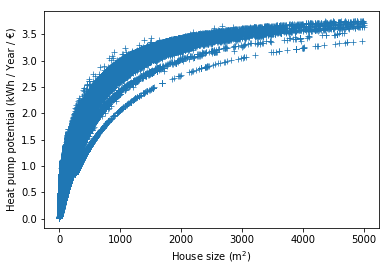

In [19]:
y = e_use_kwh.iloc[:,-4:].mean(axis = 1)[e_use_kwh['oppervlakteverblijfsobject'] < 5000]
x = e_use_kwh['oppervlakteverblijfsobject'][e_use_kwh['oppervlakteverblijfsobject'] < 5000]
fig = sns.scatterplot(x=x, y=y,marker="+")#, order = 2)
fig.set_ylabel('Heat pump potential (kWh / Year / €)')
fig.set_xlabel('House size (m$^2$)')

plt.show()

In [20]:
# x = e_use_kwh.iloc[:,-4:].mean(axis = 1)[e_use_kwh['oppervlakteverblijfsobject'] < 5000]
# y = e_use_kwh['oppervlakteverblijfsobject'][e_use_kwh['oppervlakteverblijfsobject'] < 5000]
# fig = sns.scatterplot(x=x, y=y,marker="+", hue = e_use_kwh['Energielabel'] )#, order = 2)
# fig.set_xlabel('Mean heat pump potential (GJ / Year / €)')
# fig.set_ylabel('House size (m$^2$)')

# plt.show()

In [21]:
# x = e_use_kwh.iloc[:,-4:].mean(axis = 1)[e_use_kwh['oppervlakteverblijfsobject'] < 500]
# y = e_use_kwh['oppervlakteverblijfsobject'][e_use_kwh['oppervlakteverblijfsobject'] < 500]
# fig = sns.scatterplot(x=x, y=y,marker="+", hue = e_use_kwh['Energielabel'] )#, order = 2)
# fig.set_xlabel('Mean heat pump potential (GJ / Year / €)')
# fig.set_ylabel('House size (m2)')

# plt.show()

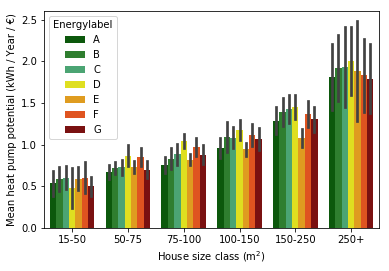

In [22]:
y = e_use_kwh.iloc[:,-4:].mean(axis = 1)
z = e_use_kwh.rename(columns = {'Energielabel': 'Energylabel'})['Energylabel']
x = e_use_kwh['GebruiksOppervlakteklasse']
order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
hue_order = ['15 tot 50 m2', '50 tot 75 m2', '75 tot 100 m2', '100 tot 150 m2', '150 tot 250 m2', '250 tot 500 m2']
palette = ['darkgreen','forestgreen','mediumseagreen','yellow','orange', 'orangered', 'darkred']
fig = sns.barplot(x=x, y=y, hue = z, ci = 'sd', order = hue_order, hue_order = order, palette = palette)#,marker="+" )#, order = 2)
fig.set_xlabel('House size class (m$^2$)')
fig.set_ylabel('Mean heat pump potential (kWh / Year / €)')
fig.set_xticklabels(['15-50','50-75','75-100','100-150','150-250','250+'], rotation=0)
#fig.get_xticklabels()
plt.show()

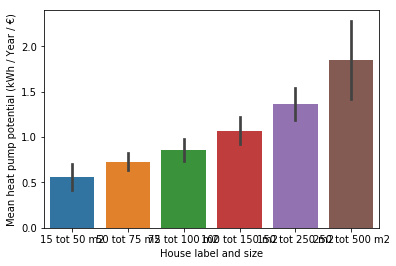

In [23]:
y = e_use_kwh.iloc[:,-4:].mean(axis = 1)
x = e_use_kwh['Energielabel']
x = e_use_kwh['GebruiksOppervlakteklasse']
order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
hue_order = ['15 tot 50 m2', '50 tot 75 m2', '75 tot 100 m2', '100 tot 150 m2', '150 tot 250 m2', '250 tot 500 m2']
fig = sns.barplot(x=x, y=y, ci = 'sd', order = hue_order)#, hue_order = hue_order)#,marker="+" )#, order = 2)
fig.set_xlabel('House label and size')
fig.set_ylabel('Mean heat pump potential (kWh / Year / €)')

plt.show()
